In [38]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from MMD import mmd_rbf, mmd_linear, mmd_poly
from tsl.datasets import AirQuality, MetrLA, PemsBay
from GRGN.Engines.Generator import Generator
from GRGN.GRGNModel import GRGNModel
from GRGN.Loss.LogLikelihood import LogLikelihood
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
import matplotlib.pyplot as plt
import torch
!export CUDA_VISIBLE_DEVICES=1

In [39]:
filename = '/data/p.magos/TSGen/logs/generation/PemsBay/PemsBay-model-epoch=03-val_loss=4.4557.ckpt'

In [40]:
filename

'/data/p.magos/TSGen/logs/generation/PemsBay/PemsBay-model-epoch=03-val_loss=4.4557.ckpt'

In [41]:
dataset = PemsBay()

adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = SpatioTemporalDataset(target=dataset.dataframe()[-1100:],
                                    covariates=None,
                                    connectivity=adj,
                                    window=1,
                                    stride=1)
scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=8)
dm.setup(stage='test')

# if cfg.get('in_sample', False):
dm.trainset = list(range(len(torch_dataset)))

/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/datasets/pems_bay.py:81: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(df.index[0], df.index[-1], freq='5T')
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/datasets/pems_bay.py:93: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)


In [42]:
loss_fn = LogLikelihood(both=True)

log_metrics = {
    '1stLL': LogLikelihood(False),
    '2ndLL': LogLikelihood(True),
    '12LL': LogLikelihood(both=True),
}

# setup generator
generator = Generator.load_from_checkpoint(filename)

In [43]:
trainer = Trainer()

trainer.ckpt_path= filename

generator.freeze()
# trainer.test(generator, datamodule=dm)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
output = trainer.predict(generator, dataloaders=dm.train_dataloader())
output = generator.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
res = dict(test_mae=loss_fn.loss(torch.tensor(y_hat), torch.tensor(y_true)))
res

Restoring states from the checkpoint path at /data/p.magos/TSGen/logs/generation/PemsBay/PemsBay-model-epoch=03-val_loss=4.4557.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /data/p.magos/TSGen/logs/generation/PemsBay/PemsBay-model-epoch=03-val_loss=4.4557.ckpt
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Predicting: |          | 0/? [00:00<?, ?it/s]

Only args ['edge_weight', 'x', 'edge_index'] are forwarded to the model (GRGNModel). 


ValueError: Type must be a sub-type of ndarray type

In [45]:
y_true = torch.tensor(y_true)
y_hat = torch.tensor(y_hat)

In [46]:
y_true.shape

input = y_true[-100:-99]
input = scalers['target'].transform(input)
input.shape

torch.Size([1, 1, 325, 1])

In [47]:
generation, out = generator.generate(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), None, 'mean', 99)

In [48]:
generation = torch.cat(generation)
true = y_true.reshape(y_true.shape[0], y_true.shape[-2])
generation = generation.reshape(generation.shape[0], generation.shape[-2])
generation = scalers['target'].inverse_transform(generation)[0]
generation.shape

torch.Size([99, 325])

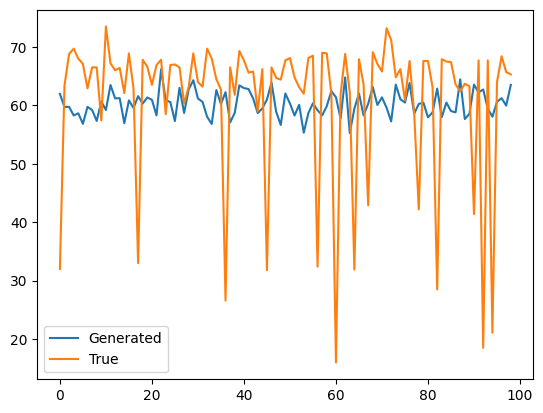

In [59]:
plt.plot(generation[:, 11], label='Generated')
plt.plot(true[-99:, 11], label='True')


plt.legend()

In [50]:
y_true.shape

input = y_true[-100:]
input = scalers['target'].transform(input)
input.shape

torch.Size([100, 1, 325, 1])

In [51]:
prediction, out = generator.predict(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), method='mean')

In [52]:
# prediction = torch.cat(prediction)
prediction1 = prediction.reshape(prediction.shape[0], prediction.shape[-1])
prediction = scalers['target'].inverse_transform(prediction1)[0]
prediction.shape

torch.Size([100, 325])

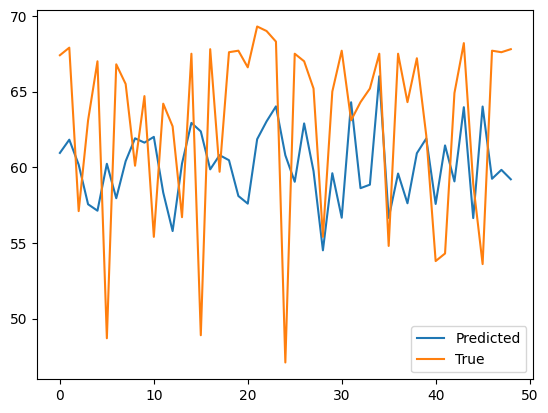

In [57]:
plt.plot(prediction[-49:, 100], label='Predicted')
plt.plot(true[-49:, 100], label='True')


# plt.plot(prediction[:, 100], label='Predicted')
# plt.plot(true[-99:, 100], label='True')
plt.legend()

In [54]:
X = true
Y = generation
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.011010928079485893

In [55]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

tensor(4433.0996)